In [40]:
#INITIALIZE SPARK SESSION
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PodPres").getOrCreate()

assembled_df = spark.read.parquet("final_features_human_labels.parquet")
assembled_df.printSchema()
assembled_df.show()  

root
 |-- segment_id: long (nullable = true)
 |-- podcast_name_cleaned: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: string (nullable = true)

+----------+--------------------+--------------------+-----+
|segment_id|podcast_name_cleaned|            features|label|
+----------+--------------------+--------------------+-----+
|         0|Bill OReillys No ...|[-4.0,0.019139915...|  0.8|
|         0|Bill OReillys No ...|[-4.0,0.019139915...|  0.5|
|         0|Bill OReillys No ...|[-4.0,0.019139915...|  0.8|
|         0|Bill OReillys No ...|[-4.0,0.019139915...|    1|
|         0|Bill OReillys No ...|[-4.0,0.019139915...|  0.7|
|         0|Bill OReillys No ...|[-4.0,0.019139915...|  0.2|
|         0|Bill OReillys No ...|[-4.0,0.019139915...|  0.4|
|         0|Bill OReillys No ...|[-4.0,0.019139915...|  0.5|
|         1|    pod save america|[10.0,0.021193129...|  0.5|
|         1|    pod save america|[10.0,0.021193129...|  0.7|
|         1|    pod save america

In [42]:
# total row
row_count = assembled_df.count()
print(f"The DataFrame has {row_count} rows.")

The DataFrame has 867 rows.


### RandomForest model training

In [43]:
from pyspark.sql.functions import when, col
from pyspark.ml.classification import RandomForestClassifier

# Set the threshold and transform the labels
assembled_df = assembled_df.withColumn("binary_label", when(col("label") >=0.5, 1).otherwise(0))

# Classify using RandomForest with parameters: numTrees: 20, maxDepth: 5, maxBins: 32
rf = RandomForestClassifier(featuresCol='features', labelCol='binary_label')

# Train the model
rfModel = rf.fit(assembled_df)

# Model evaluation
predictions = rfModel.transform(assembled_df)
predictions.select("binary_label", "prediction", "probability").show(50, truncate=False)

+------------+----------+----------------------------------------+
|binary_label|prediction|probability                             |
+------------+----------+----------------------------------------+
|1           |1.0       |[0.3233472129622219,0.6766527870377781] |
|1           |1.0       |[0.3233472129622219,0.6766527870377781] |
|1           |1.0       |[0.3233472129622219,0.6766527870377781] |
|1           |1.0       |[0.3233472129622219,0.6766527870377781] |
|1           |1.0       |[0.3233472129622219,0.6766527870377781] |
|0           |1.0       |[0.3233472129622219,0.6766527870377781] |
|0           |1.0       |[0.3233472129622219,0.6766527870377781] |
|1           |1.0       |[0.3233472129622219,0.6766527870377781] |
|1           |1.0       |[0.29368956538353436,0.7063104346164657]|
|1           |1.0       |[0.29368956538353436,0.7063104346164657]|
|1           |1.0       |[0.29368956538353436,0.7063104346164657]|
|0           |1.0       |[0.29368956538353436,0.70631043461646

In [44]:
from pyspark.sql.functions import col

prediction_counts = predictions.groupBy("prediction").count()
# result
prediction_counts.show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  172|
|       1.0|  695|
+----------+-----+



In [45]:
total_count = prediction_counts.groupBy().sum("count").collect()[0][0]
# Adding a percentage column
prediction_counts = prediction_counts.withColumn("percentage", col("count") / total_count)

# Display the updated DataFrame
prediction_counts.show()
# Collect data for use in Python
collected_data = prediction_counts.collect()

# Iterate and print specific prediction probabilities
for row in collected_data:
    if row.prediction == 0.0:
        print(f"Biden win probability: {row.percentage * 100:.2f}%")
    elif row.prediction == 1.0:
        print(f"Trump win probability: {row.percentage * 100:.2f}%")


+----------+-----+-------------------+
|prediction|count|         percentage|
+----------+-----+-------------------+
|       0.0|  172|0.19838523644752018|
|       1.0|  695| 0.8016147635524798|
+----------+-----+-------------------+

Biden win probability: 19.84%
Trump win probability: 80.16%


In [46]:
from pyspark.ml.tuning import ParamGridBuilder

# Conducting grid-search
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 50]).addGrid(rf.maxDepth, [5, 10, 20]).addGrid(rf.maxBins, [32, 64]).build()

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Set up the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="binary_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Create a cross-validator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  # Using 5-fold cross-validation

# Run cross-validation to find the best model
cvModel = crossval.fit(assembled_df)

# Get the best model
bestModel = cvModel.bestModel

24/05/11 04:59:05 WARN DAGScheduler: Broadcasting large task binary with size 1021.1 KiB
24/05/11 04:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1172.2 KiB
24/05/11 04:59:09 WARN DAGScheduler: Broadcasting large task binary with size 1074.8 KiB
24/05/11 04:59:09 WARN DAGScheduler: Broadcasting large task binary with size 1226.0 KiB
24/05/11 04:59:12 WARN DAGScheduler: Broadcasting large task binary with size 1021.1 KiB
24/05/11 04:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1172.2 KiB
24/05/11 04:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1295.5 KiB
24/05/11 04:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1378.9 KiB
24/05/11 04:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1422.3 KiB
24/05/11 04:59:14 WARN DAGScheduler: Broadcasting large task binary with size 1272.3 KiB
24/05/11 04:59:14 WARN DAGScheduler: Broadcasting large task binary with size 1221.6 KiB
24/05/11 04:59:17 WAR

In [47]:
# Using the best model for predictions
bestPredictions = bestModel.transform(assembled_df)

# Display the first 50 prediction results
bestPredictions.select("binary_label", "prediction", "probability").show(truncate=False)
print("Best Model Params:", bestModel.explainParams())

+------------+----------+----------------------------------------+
|binary_label|prediction|probability                             |
+------------+----------+----------------------------------------+
|1           |1.0       |[0.19533604077377553,0.8046639592262245]|
|1           |1.0       |[0.19533604077377553,0.8046639592262245]|
|1           |1.0       |[0.19533604077377553,0.8046639592262245]|
|1           |1.0       |[0.19533604077377553,0.8046639592262245]|
|1           |1.0       |[0.19533604077377553,0.8046639592262245]|
|0           |1.0       |[0.19533604077377553,0.8046639592262245]|
|0           |1.0       |[0.19533604077377553,0.8046639592262245]|
|1           |1.0       |[0.19533604077377553,0.8046639592262245]|
|1           |1.0       |[0.18474122117680133,0.8152587788231986]|
|1           |1.0       |[0.18474122117680133,0.8152587788231986]|
|1           |1.0       |[0.18474122117680133,0.8152587788231986]|
|0           |1.0       |[0.18474122117680133,0.81525877882319

In [48]:
best_prediction_counts = bestPredictions.groupBy("prediction").count()
# result
best_prediction_counts.show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  355|
|       1.0|  512|
+----------+-----+



In [49]:

total_count = best_prediction_counts.groupBy().sum("count").collect()[0][0]
from pyspark.sql.functions import col

# Adding a percentage column
best_prediction_counts = best_prediction_counts.withColumn("percentage", col("count") / total_count)

# Display the updated DataFrame
best_prediction_counts.show()
# Collect data for use in Python
collected_data = best_prediction_counts.collect()

# Iterate and print specific prediction probabilities
for row in collected_data:
    if row.prediction == 0.0:
        print(f"Biden win probability: {row.percentage * 100:.2f}%")
    elif row.prediction == 1.0:
        print(f"Trump win probability: {row.percentage * 100:.2f}%")


+----------+-----+-------------------+
|prediction|count|         percentage|
+----------+-----+-------------------+
|       0.0|  355|0.40945790080738176|
|       1.0|  512| 0.5905420991926182|
+----------+-----+-------------------+

Biden win probability: 40.95%
Trump win probability: 59.05%


### Evaluation

Area under ROC = 0.715109775623451
Area under PR = 0.7803057228360594


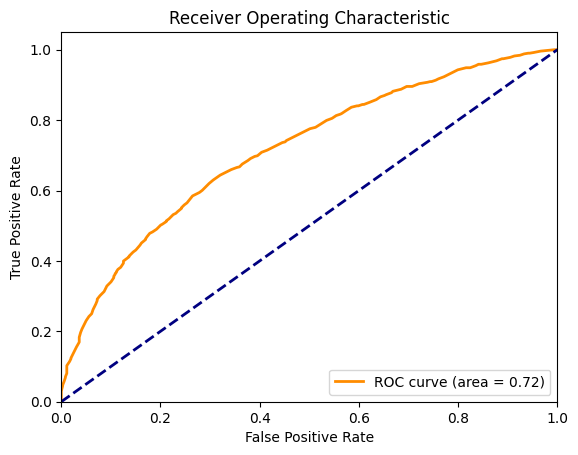

In [50]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtain probabilities and actual labels
probabilities = bestPredictions.select("probability").rdd.map(lambda x: x[0][1]).collect()
labels = bestPredictions.select("binary_label").rdd.map(lambda x: x[0]).collect()

# Convert results to RDD and compute evaluation metrics
results_rdd = bestPredictions.select(['probability', 'binary_label']).rdd.map(lambda row: (float(row['probability'][1]), float(row['binary_label'])))
metrics = BinaryClassificationMetrics(results_rdd)

# Output AUC calculated by PySpark
print("Area under ROC = %s" % metrics.areaUnderROC)
print("Area under PR = %s" % metrics.areaUnderPR)

# Use sklearn to calculate the ROC curve
fpr, tpr, thresholds = roc_curve(labels, probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [51]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create an instance of the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="binary_label", predictionCol="prediction")

# Calculate accuracy
accuracy = evaluator.evaluate(bestPredictions, {evaluator.metricName: "accuracy"})
print("Accuracy = %s" % accuracy)

# Calculate weighted precision
weightedPrecision = evaluator.evaluate(bestPredictions, {evaluator.metricName: "weightedPrecision"})
print("Weighted Precision = %s" % weightedPrecision)

# Calculate weighted recall
weightedRecall = evaluator.evaluate(bestPredictions, {evaluator.metricName: "weightedRecall"})
print("Weighted Recall = %s" % weightedRecall)

# Calculate F1 score
f1 = evaluator.evaluate(bestPredictions, {evaluator.metricName: "f1"})
print("F1 Score = %s" % f1)


Accuracy = 0.6608996539792388
Weighted Precision = 0.6603578543057653
Weighted Recall = 0.6608996539792388
F1 Score = 0.6606146957052716


In [52]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert data to RDD for evaluation
predictionAndLabels = bestPredictions.select("prediction", "binary_label").rdd.map(lambda r: (float(r[0]), float(r[1])))

# Initialize a multiclass metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Retrieve and print the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n", confusion_matrix)


Confusion Matrix:
 [[210. 149.]
 [145. 363.]]


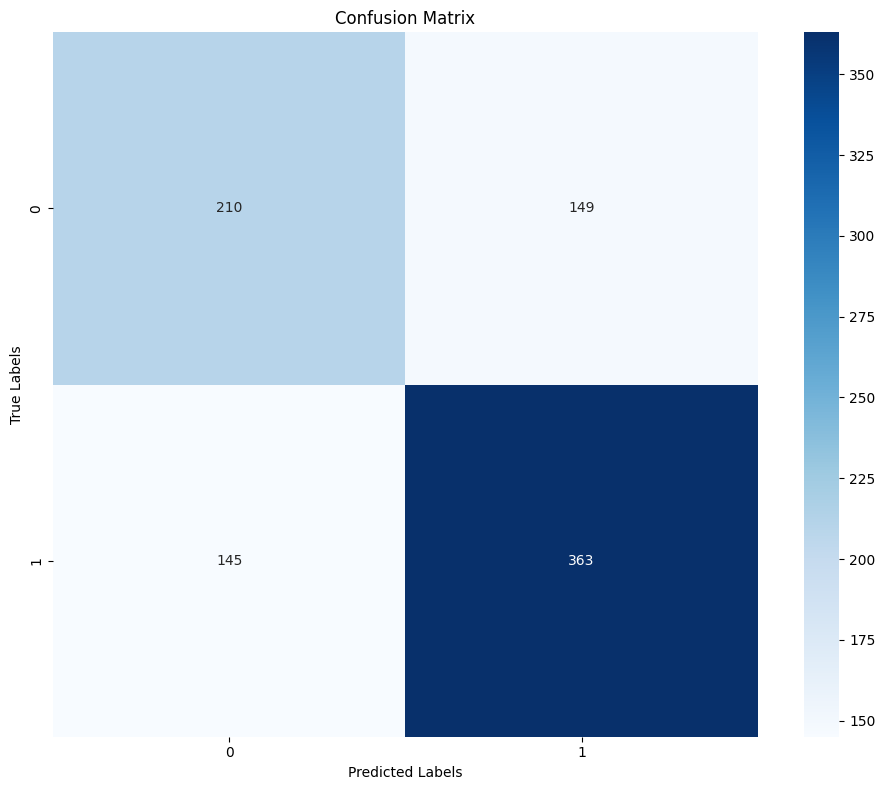

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap='Blues', square=True)

# Add title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


In [54]:
spark.stop()